In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import scipy
import pickle
import warnings
import bidict
import collections

import sys
sys.path.append('..')
from construct_graph.graph import Graph, Flat
import construct_graph
import solve_laplace_operator

import sparseqr

from IPython.display import display, HTML

display(HTML("""
<style>
.jp-OutputArea-output {max-width: 100% !important;}
.jp-Cell-outputWrapper {max-width: 100% !important;}
.jp-OutputArea-output pre {max-width: 100% !important;}
</style>
"""))

def calculate_pde_eigenvalues(m, n):
    a = 1 / 2
    return np.sqrt(((2 * np.pi * m)**2 + (2 * np.pi * n)**2) * a)

def style_plot(fig, ax, aspect="equal", label_fontsize=20, no_ticks=False, no_xticks=False, no_yticks=False):

    # Remove white space
    fig.tight_layout()

    # Makes axes aspect equal
    if aspect == "equal":
        ax.set_aspect(aspect)

    # Make tick labels bold font
    for label in ax.get_xticklabels(minor=True) + ax.get_yticklabels(minor=True):
        label.set_fontweight('bold')
        label.set_fontsize(label_fontsize)

    for label in (ax.get_xticklabels(minor=False) + ax.get_yticklabels(minor=False)):
        label.set_fontweight('bold')
        label.set_fontsize(label_fontsize)

    # Make border thicker
    for spine in ax.spines.values():
        spine.set_linewidth(2) 

    # xy_ticks
    major_tick_length = 7
    minor_tick_length = 4
    if no_ticks:
        major_xtick_length = 0
        major_ytick_length = 0
        minor_xtick_length = 0
        minor_ytick_length = 0
    elif no_xticks:
        major_xtick_length = 0
        major_ytick_length = major_tick_length
        minor_xtick_length = 0
        minor_ytick_length = minor_tick_length
    elif no_yticks:
        major_xtick_length = major_tick_length
        major_ytick_length = 0
        minor_xtick_length = minor_tick_length
        minor_ytick_length = 0
    else:
        major_xtick_length = major_tick_length
        major_ytick_length = major_tick_length
        minor_xtick_length = minor_tick_length
        minor_ytick_length = minor_tick_length
    ax.tick_params(axis='x', which='major', length=major_xtick_length, width=2, direction='out')
    ax.tick_params(axis='y', which='major', length=major_ytick_length, width=2, direction='out')
    ax.tick_params(axis='x', which='minor', length=minor_xtick_length, width=1, direction='out')
    ax.tick_params(axis='y', which='minor', length=minor_ytick_length, width=1, direction='out')

In [6]:
class Delaunay_Graph:

    def __init__(self, full_num_Vs, box_side_lengths=[1, 1]):

        self.full_num_Vs = full_num_Vs
        self.box_side_lengths = box_side_lengths
        self.construct_V_coords()
        
    def construct_V_coords(self):

        min_coord = -0.2
        max_coord = 1.2

        full_V_coords = np.random.uniform(min_coord, max_coord, size=(self.full_num_Vs, 2))
        bulk_mask = ((0 < full_V_coords[:, 0]) & (0 < full_V_coords[:, 1]) 
                     & (full_V_coords[:, 0] < 1) & (full_V_coords[:, 1] < 1))
        num_Vs = np.sum(bulk_mask)
        full_V_coords = np.vstack((full_V_coords[bulk_mask], full_V_coords[~bulk_mask]))

        # Construct edges
        triangulation = scipy.spatial.Delaunay(full_V_coords)
        V, W = triangulation.vertex_neighbor_vertices
        edges = []
        for v_ind in range(self.full_num_Vs):
            w_inds = W[V[v_ind]:V[v_ind + 1]]
            for w_ind in w_inds:
                if v_ind < w_ind:
                    edges.append([v_ind, w_ind])
        edges = np.array(edges)
        edges = np.sort(edges, axis=1)

        # Define class attributes
        self.full_V_coords = full_V_coords
        self.edges = edges
        self.num_Vs = num_Vs
        self.triangulation = triangulation
            
class RGG:

    def __init__(self, full_num_Vs, box_side_lengths=[1, 1]):

        self.full_num_Vs = full_num_Vs
        self.box_side_lengths = box_side_lengths
        self.construct_V_coords()

    def construct_V_coords(self):

        min_coord = -0.2
        max_coord = 1.2

        full_V_coords = np.random.uniform(min_coord, max_coord, size=(self.full_num_Vs, 2))
        bulk_mask = ((0 < full_V_coords[:, 0]) & (0 < full_V_coords[:, 1]) 
                     & (full_V_coords[:, 0] < 1) & (full_V_coords[:, 1] < 1))
        num_Vs = np.sum(bulk_mask)
        full_V_coords = np.vstack((full_V_coords[bulk_mask], full_V_coords[~bulk_mask]))

        # Construct edges
        tree = scipy.spatial.cKDTree(full_V_coords)
        mean_l = 2.5 * np.abs(max_coord - min_coord) / np.sqrt(self.full_num_Vs)
        edges = np.array(list(tree.query_pairs(r=mean_l)))
        edges = np.sort(edges, axis=1)

        # Define class attributes
        self.full_V_coords = full_V_coords
        self.edges = edges
        self.num_Vs = num_Vs

class Aperiodic_Monotile:

    def __init__(self, N):

        self.construct_V_coords(N)

    def construct_V_coords(self, N):

        file = open("grid_size_150_data/V_coords.pkl", "rb")
        full_V_coords = pickle.load(file)
        file.close()
        file = open("grid_size_150_data/E_lengths_by_v_num.pkl", "rb")
        full_E_lengths_by_v_num = pickle.load(file)
        file.close()

        translate = np.array([0.1, -50.1])
        full_V_coords += translate

        bulk_mask = ((0 < full_V_coords[:, 0]) & (0 < full_V_coords[:, 1]) 
                     & (full_V_coords[:, 0] < N) & (full_V_coords[:, 1] < N))

        full_V_coords = np.vstack((full_V_coords[bulk_mask], full_V_coords[~bulk_mask])) / N

        old_inds = np.concatenate((np.argwhere(bulk_mask).flatten(), np.argwhere(~bulk_mask).flatten()))
        new_inds = np.arange(full_V_coords.shape[0])
        remap = {i: j for i, j in zip(old_inds, new_inds)}

        old_edges = np.array(list(full_E_lengths_by_v_num.keys()))
        edges = []
        for v_ind, w_ind in old_edges:
            edges.append([remap[v_ind], remap[w_ind]])
        edges = np.array(edges)
        edges = np.sort(edges, axis=1)

        num_Vs = np.sum(bulk_mask)

        bulk_edges = []
        for i, j in edges:
            if i < num_Vs and j < num_Vs:
                bulk_edges.append([i, j])
        bulk_V_inds = np.unique(bulk_edges)
        disconnected_V_inds = set(np.arange(num_Vs)) - set(bulk_V_inds)
        if len(disconnected_V_inds) > 0:
            all_ok_inds = set(np.arange(full_V_coords.shape[0])) - disconnected_V_inds
            old_inds = np.concatenate((np.array(list(all_ok_inds)), np.array(list(disconnected_V_inds))))
            full_V_coords = full_V_coords[old_inds]
            new_inds = np.arange(full_V_coords.shape[0])
            remap = {i: j for i, j in zip(old_inds, new_inds)}
            new_edges = []
            for v_ind, w_ind in edges:
                new_edges.append([remap[v_ind], remap[w_ind]])
            new_edges = np.array(new_edges)
            edges = np.sort(new_edges, axis=1)
            num_Vs -= len(disconnected_V_inds)

        # Define class attributes
        self.full_V_coords = full_V_coords
        self.edges = edges
        self.num_Vs = num_Vs

In [7]:
class Patch_Graph:
    """
    g needs:
        - num_Vs            : int (number of vertices in bulk)
        - full_V_coords     : Nx2 np.array (first num_Vs are the bulk vertices)
        - edges             : Nx2 np.array (each row must be sorted ascending)
        - box_side_lengths  : list (NOT YET INCLUDED. BOX ASSUMED 1x1 FOR NOW)"""

    def __init__(self, parent_graph, autoplot=False):

        self.construct_bulk_and_boundary_attributes(parent_graph)
        print(f"num_Vs = {self.num_Vs}")
        self.construct_boundary_to_bulk_attributes()

        self.construct_NEP_data()

        if autoplot:
            self.plot_graph(parent_graph)

    def construct_NEP_data(self):

        self.interior_V_num = np.arange(self.num_Vs)
        self.wadjacency_matrices = self.construct_wadjacencies()

    def calculate_csc(self, k, l):
        return 1 / np.sin(k * l)
    
    def calculate_sec(self, k, l):
        return 1 / np.cos(k * l)
    
    def calculate_cot(self, k, l):
        return 1 / np.tan(k * l)

    def calculate_dcsc(self, k, l):
        return -l * self.calculate_csc(k, l) * self.calculate_cot(k, l)

    def calculate_dcot(self, k, l):
        return -l * self.calculate_csc(k, l)**2

    def calculate_dsec(self, k, l):
        return l * self.calculate_sec(k, l) * np.tan(k * l)
    
    def construct_wadjacencies(self):

        wadjacency_matrices = []

        bulk_wadjacency_matrix = scipy.sparse.lil_matrix((self.num_Vs, self.num_Vs))
        for v_ind, w_ind in self.edges:
            l_vw = self.calculate_l_vw(v_ind, w_ind)
            bulk_wadjacency_matrix[v_ind, w_ind] = l_vw
            bulk_wadjacency_matrix[w_ind, v_ind] = l_vw
        bulk_wadjacency_matrix = bulk_wadjacency_matrix.tocsc()

        wadjacency_matrices.append(bulk_wadjacency_matrix)

        boundary_wadjacency_matrices = []
        for v_ind, w_ind in self.periodic_edges:
            for v_coords, w_coords in self.periodic_edges[v_ind, w_ind]:
                boundary_wadjacency_matrix = scipy.sparse.lil_matrix((self.num_Vs, self.num_Vs))
                l_vw = np.linalg.norm(v_coords - w_coords)
                boundary_wadjacency_matrix[v_ind, w_ind] = l_vw
                boundary_wadjacency_matrix[w_ind, v_ind] = l_vw
                boundary_wadjacency_matrix = boundary_wadjacency_matrix.tocsc()
                boundary_wadjacency_matrices.append(boundary_wadjacency_matrix)

        wadjacency_matrices += boundary_wadjacency_matrices

        return wadjacency_matrices

    def construct_L(self, k, deriv=False):

        if not deriv:
            calculate_csc = self.calculate_csc
            calculate_cot = self.calculate_cot
        else:
            calculate_csc = self.calculate_dcsc
            calculate_cot = self.calculate_dcot

        L = scipy.sparse.lil_matrix((self.num_Vs, self.num_Vs))

        for wadjacency_matrix in self.wadjacency_matrices[:1]:

            matrix_csc = wadjacency_matrix.copy()
            matrix_csc.data = calculate_csc(k, matrix_csc.data)

            matrix_cot = wadjacency_matrix.copy()
            matrix_cot.data = calculate_cot(k, matrix_cot.data)
            matrix_cot = scipy.sparse.diags(matrix_cot.sum(axis=0).flat)

            L += matrix_cot - matrix_csc

        for wadjacency_matrix in self.wadjacency_matrices[1:]:
            v, w = wadjacency_matrix.nonzero()[0]
            csc = calculate_csc(k, wadjacency_matrix[v, w])
            cot = calculate_cot(k, wadjacency_matrix[v, w])
            L[v, w] -= csc
            L[w, v] -= csc
            L[v, v] += cot
            L[w, w] += cot

        L = L.tocsc()

        return L

    def construct_bulk_and_boundary_attributes(self, parent_graph):

        # Loop through v_ind, w_ind in parent_graph.edges. Construct edges and boundary edges. 
        # Indices are ordered so we know which vertices are in the graph/bulk, and which are boundary.
        # Construct also boundary vertex indices.
        edges = []
        boundary_edges = []
        boundary_V_inds = []
        for v_ind, w_ind in parent_graph.edges:
            if v_ind < parent_graph.num_Vs:
                edge = [v_ind, w_ind]
                if w_ind < parent_graph.num_Vs:
                    edges.append(edge)
                else:
                    w_coords = parent_graph.full_V_coords[w_ind]
                    if (not np.any(w_coords < 0)) or (w_coords[0] > 1 and w_coords[1] < 0):
                        boundary_V_inds.append(w_ind)
                        boundary_edges.append(edge)
        boundary_V_inds = np.unique(boundary_V_inds)
        V_coords = parent_graph.full_V_coords[:parent_graph.num_Vs]
        boundary_V_coords = parent_graph.full_V_coords[boundary_V_inds]
        num_Vs = V_coords.shape[0]
        num_boundary_Vs = boundary_V_coords.shape[0]
        reindex_boundary_V_coords = {i: en for en, i in enumerate(boundary_V_inds)}

        # edges is [v_ind, w_ind] where 0 <= v_ind, w_ind <= num_Vs - 1
        # boundary_edges is [v_ind, w_ind] where 0 <= v_ind <= num_Vs - 1 and 0 <= w_ind <= num_boundary_Vs - 1
        edges = np.array(edges)
        boundary_edges = np.array([[i, reindex_boundary_V_coords[j]] for i, j in boundary_edges])

        # Define bulk attributes
        self.V_coords = V_coords
        self.edges = edges
        self.num_Vs = num_Vs
        # Define boundary attributes
        self.boundary_V_coords = boundary_V_coords
        self.boundary_edges = boundary_edges
        self.num_boundary_Vs = num_boundary_Vs

    def construct_boundary_to_bulk_attributes(self):

        # Construct boundary map
        boundary_to_bulk_map = {}
        for v_ind, v_coords in enumerate(self.boundary_V_coords):
            wrapped_v_coords = v_coords % 1
            distances = np.linalg.norm(self.V_coords - wrapped_v_coords, axis=1)
            wrapped_v_ind = distances.argmin()
            boundary_to_bulk_map[v_ind] = wrapped_v_ind

        periodic_edges = collections.defaultdict(list)
        for v_ind, w_ind in self.boundary_edges:
            bulk_w_ind = boundary_to_bulk_map[w_ind]
            periodic_edges[(v_ind, bulk_w_ind)].append(np.array((self.V_coords[v_ind], self.boundary_V_coords[w_ind])))

        # Define boundary to bulk attributes
        self.boundary_to_bulk_map = boundary_to_bulk_map
        self.periodic_edges = periodic_edges

    def construct_alpha_solve(self):

        LHS = scipy.sparse.lil_matrix((self.num_Vs + 1, self.num_Vs))

        for v_ind, w_ind in self.edges:
            l_vw = self.calculate_l_vw(v_ind, w_ind)
            LHS[v_ind, w_ind] -= 1 / l_vw
            LHS[w_ind, v_ind] -= 1 / l_vw
            LHS[v_ind, v_ind] += 1 / l_vw
            LHS[w_ind, w_ind] += 1 / l_vw

        for v_ind, w_ind in self.periodic_edges:
            for v_coords, w_coords in self.periodic_edges[v_ind, w_ind]:
                l_vw = np.linalg.norm(v_coords - w_coords)
                LHS[v_ind, w_ind] -= 1 / l_vw
                LHS[w_ind, v_ind] -= 1 / l_vw
                LHS[v_ind, v_ind] += 1 / l_vw
                LHS[w_ind, w_ind] += 1 / l_vw

        RHS = scipy.sparse.lil_matrix((self.num_Vs + 1, 2))
        for v_ind, w_ind in self.periodic_edges:
            for v_coords, w_coords in self.periodic_edges[v_ind, w_ind]:
                l_vw = np.linalg.norm(v_coords - w_coords)
                v_x_coords = self.v_coords_to_x_coords(v_coords)
                w_x_coords = self.v_coords_to_x_coords(w_coords) 
                r_xy = w_x_coords - v_x_coords
                RHS[v_ind] += r_xy / l_vw
                RHS[w_ind] -= r_xy / l_vw

        LHS[-1] = np.ones(self.num_Vs)
        LHS = LHS.tocsc()
        RHS = RHS.tocsc()

        return LHS, RHS

    # def construct_boundary_edges(self):

        # # Construct boundary map
        # boundary_to_bulk_map = {}
        # for v_ind, v_coords in enumerate(boundary_V_coords):
        #     wrapped_v_coords = v_coords % 1
        #     r_xy = v_coords - wrapped_v_coords
        #     distances = np.linalg.norm(V_coords - wrapped_v_coords, axis=1)
        #     wrapped_v_ind = distances.argmin()
        #     boundary_to_bulk_map[v_ind] = [wrapped_v_ind, r_xy]

        # # For remapping bulk to boundary to **update** exact l_vw's
        # periodic_edges = {}
        # for v_ind, w_ind in boundary_edges:
        #     w_ind, w_translation = boundary_to_bulk_map[w_ind]
        #     periodic_edges[(v_ind, w_ind)] = np.array((V_coords[v_ind], V_coords[w_ind] + w_translation))

    def plot_graph(self, parent_graph):

        # Plot graph
        fig = plt.figure(figsize=(9, 9))
        ax = fig.add_subplot(111)
        # ax.set_xlim(-0.1, 1.1)
        # ax.set_ylim(-0.1, 1.1)

        ax.add_patch(matplotlib.patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='orange', facecolor='none'))

        # Plot the lines between neighbors
        for i, j in self.edges:
            point1 = self.V_coords[i]
            point2 = self.V_coords[j]
            ax.plot([point1[0], point2[0]], [point1[1], point2[1]], 'blue', linewidth=1)
        for i, j in self.periodic_edges:
            for point1, point2 in self.periodic_edges[i, j]:
                ax.plot([point1[0], point2[0]], [point1[1], point2[1]], 'green', linewidth=1)
        
        # ax.triplot(parent_graph.full_V_coords[:, 0], parent_graph.full_V_coords[:, 1], parent_graph.triangulation.simplices)

        # ax.scatter(self.V_coords[:, 0], self.V_coords[:, 1], color='blue', s=30, zorder=10)
        ax.scatter(self.boundary_V_coords[:, 0], self.boundary_V_coords[:, 1], color='red', s=30, zorder=10)

        # for en, v in enumerate(self.V_coords):
        #     ax.annotate(str(en), v, fontsize=20)

        # for en, v in enumerate(self.boundary_V_coords):
        #     ax.annotate(str(en), v, fontsize=20)

    def calculate_l_vw(self, v_ind, w_ind):
        return np.linalg.norm(self.V_coords[v_ind] - self.V_coords[w_ind])

    def v_coords_to_x_coords(self, v_coords):
        x_coords = []
        for d in range(v_coords.shape[0]):
            if v_coords[d] < 0:
                x_coords.append(-0.5)
            elif v_coords[d] < 1:
                x_coords.append(0.5)
            else:
                x_coords.append(1.5)
        x_coords = np.array(x_coords)

        return x_coords

## Delaunay triangulation

In [5]:
nums_Vs = (10**np.linspace(2, 4, 13) * 2).astype(int)

In [507]:
# eigenvalues = {}
for en, num_Vs in enumerate(nums_Vs[6:]):
    print(f"\n\n\nGRAPH {en + 6} / 12\n\n\n")
    eigenvalues[int(num_Vs / 2)] = []
    if num_Vs / 2 < 900:
        guesses = np.linspace(3.8, 4.6, 60)
        num_seeds = 64
    elif num_Vs / 2 < 4000:
        guesses = np.linspace(4.05, 4.5, 30)
        num_seeds = 16
    else:
        guesses = np.linspace(4.15, 4.35, 20)
        num_seeds = 4
    for seed in range(num_seeds):
        print(f"seed = {seed}")
        np.random.seed(seed)
        pg = Delaunay_Graph(num_Vs)
        g = Patch_Graph(pg)
        eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
        solutions = eigs(guesses, solve_type="SVD iterate", printerval=np.inf, max_steps=20)
        print(g.num_Vs)
        print(np.unique(np.round(solutions, 8)))
        print()
        _, inds = np.unique(np.round(solutions, 8), return_index=True)
        eigenvalues[int(num_Vs / 2)].append(solutions[inds])




GRAPH 6 / 12



seed = 0
num_Vs = 988
988
[4.15692013 4.23571818 4.26404536 4.39917533]

seed = 1
num_Vs = 1025
1025
[4.13304219 4.24471129 4.321375   4.38636372]

seed = 2
num_Vs = 987
987
[4.21954308 4.28262913 4.33671149 4.36098986]

seed = 3
num_Vs = 1037
1037
[4.15468901 4.18856214 4.27468788 4.37100659]

seed = 4
num_Vs = 989
989
[4.12506827 4.27258665 4.31549176 4.4170999 ]

seed = 5
num_Vs = 1046
1046
[4.13953383 4.20926671 4.27348135 4.3708601 ]

seed = 6
num_Vs = 1014
1014
[4.07144916 4.13208251 4.323669   4.47128509]

seed = 7
num_Vs = 1024
1024
[4.14670176 4.20956048 4.29586098 4.41403733]

seed = 8
num_Vs = 1024
1024
[4.14346947 4.17389809 4.35630663 4.42509269]

seed = 9
num_Vs = 1028
1028
[4.14503476 4.27164931 4.29775575 4.35522332]

seed = 10
num_Vs = 1016
1016
[4.16422029 4.22256818 4.27843126 4.35079604]

seed = 11
num_Vs = 1031
1031
[4.11489305 4.24010024 4.25793872 4.43147558]

seed = 12
num_Vs = 1024
1024
[4.10755437 4.1766818  4.36594866 4.37731854]

seed = 13

## RGG

In [49]:
nums_Vs = (10**np.linspace(2, 4, 13) * 2).astype(int)

In [50]:
eigenvalues_RGG = {}
for en, num_Vs in enumerate(nums_Vs):
    print(f"\n\n\nGRAPH {en} / 12\n\n\n")
    eigenvalues_RGG[int(num_Vs / 2)] = []
    if num_Vs / 2 < 900:
        guesses = np.linspace(3, 4.8, 40)
        num_seeds = 64
    elif num_Vs / 2 < 4000:
        guesses = np.linspace(3, 4.8, 20)
        num_seeds = 16
    else:
        guesses = np.linspace(3.78, 4.1, 15)
        num_seeds = 4
    for seed in range(num_seeds):
        print(f"seed = {seed}")
        np.random.seed(seed)
        pg = RGG(num_Vs)
        g = Patch_Graph(pg)
        eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
        solutions = []
        for guess in guesses:
            solution = eigs(guess, solve_type="SVD iterate", printerval=np.inf, tol=1e-4, max_steps=20)
            solutions.append(solution)
            _, index = np.unique(np.round(solutions, 3), return_index=True)
            solutions = list(np.array(solutions)[index])
        full_solutions = eigs(solutions, solve_type="SVD iterate", printerval=np.inf, tol=1e-13, max_steps=20)
        print(g.num_Vs)
        print(np.unique(np.round(full_solutions, 8)))
        print()
        _, inds = np.unique(np.round(full_solutions, 8), return_index=True)
        eigenvalues_RGG[int(num_Vs / 2)].append(full_solutions[inds])




GRAPH 0 / 12



seed = 0
num_Vs = 96
96
[3.40840703 3.5838606  4.48313272 4.71306054]

seed = 1
num_Vs = 93
93
[3.5118923  3.92646028 4.28212215 5.0782609 ]

seed = 2
num_Vs = 104
104
[3.3301515  3.95394116 4.276673   4.90982064]

seed = 3
num_Vs = 110
110
[3.00402311 3.76182402 4.52368508 4.93645353]

seed = 4
num_Vs = 98
98
[3.26002238 3.86066447 4.38084327 4.95726948]

seed = 5
num_Vs = 104
104
[3.63019738 4.07064282 4.287312   4.81731526]

seed = 6
num_Vs = 97
97
[3.65725044 4.03559779 4.50243234]

seed = 7
num_Vs = 102
102
[2.8831801  4.03979827 4.50956529]

seed = 8
num_Vs = 106
106
[3.63299468 3.85798173 4.29160288 4.78159415]

seed = 9
num_Vs = 107
107
[3.55363395 3.95521722 4.36127378 4.80990954]

seed = 10
num_Vs = 104
104
[3.56529446 3.70729692 4.04601512 4.96680571]

seed = 11
num_Vs = 102
102
[3.00235299 3.52121227 3.84478284 5.0148662 ]

seed = 12
num_Vs = 101
101
[3.45184338 3.70942901 4.06650913 4.8994137 ]

seed = 13
num_Vs = 94
94
[2.87512379 3.49827281 4.69145197]

/var/folders/8c/ybs90zyn3yn3tyx860br5cc40000gn/T/ipykernel_72897/322237499.py:26: RuntimeWarning: divide by zero encountered in divide
  return 1 / np.sin(k * l)
/var/folders/8c/ybs90zyn3yn3tyx860br5cc40000gn/T/ipykernel_72897/322237499.py:32: RuntimeWarning: divide by zero encountered in divide
  return 1 / np.tan(k * l)
/var/folders/8c/ybs90zyn3yn3tyx860br5cc40000gn/T/ipykernel_72897/322237499.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 / np.sin(k * l)
/var/folders/8c/ybs90zyn3yn3tyx860br5cc40000gn/T/ipykernel_72897/322237499.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 / np.tan(k * l)


Factor is exactly singular
Factor is exactly singular
140
[2.68821372 3.4777931  4.59687627 4.61803141        nan]

seed = 14
num_Vs = 150
150
[3.41375158 3.98523811 4.31210227 4.58290959]

seed = 15
num_Vs = 146
146
[3.27898507 3.76074214 4.42295681 4.77468293]

seed = 16
num_Vs = 143
143
[3.08663387 3.66814214 4.00264946 4.88567071]

seed = 17
num_Vs = 149
149
[3.31329068 3.88202998 4.58503383 4.7328567 ]

seed = 18
num_Vs = 156
156
[3.48165716 3.81227402 4.49960434 4.67737843]

seed = 19
num_Vs = 151
151
[3.26346078 3.55862933 4.52558827 4.73711696]

seed = 20
num_Vs = 148
148
[3.36771523 3.68414275 4.47210996 4.71954158]

seed = 21
num_Vs = 151
151
[3.52325124 3.95805432 4.33341568 4.65798157]

seed = 22
num_Vs = 146
146
[3.10628365 4.13696193 4.28655587 4.89795917]

seed = 23
num_Vs = 151
151
[3.35858526 3.71717914 4.18057133 4.76770969]

seed = 24
num_Vs = 141
141
[3.49598031 4.18568232 4.41760771 4.8291939 ]

seed = 25
num_Vs = 144
144
[3.07213874 3.60378709 4.58150597]

seed = 

num_Vs = 255


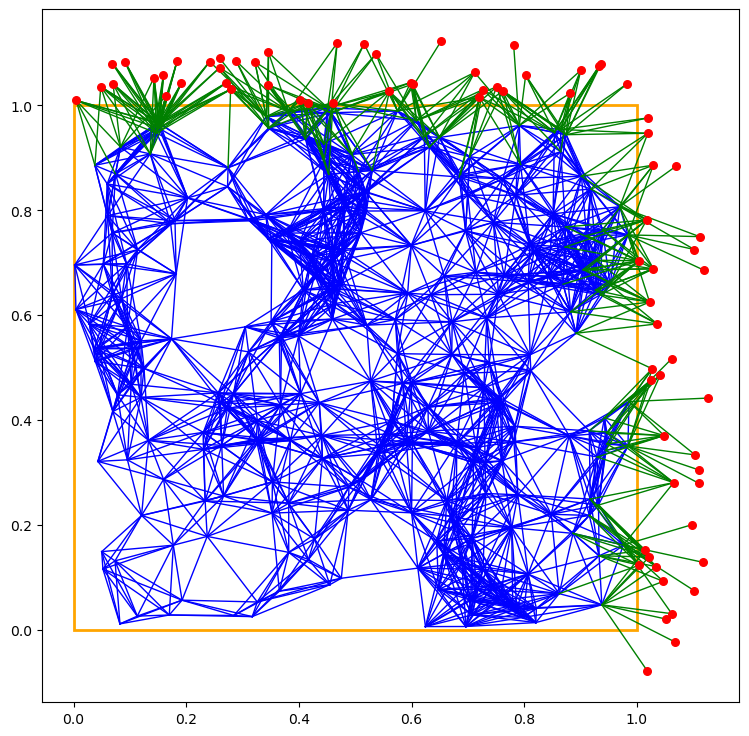

In [78]:
pg = RGG(500)
g = Patch_Graph(pg, autoplot=True)

In [80]:
eigenvalues_RGG.keys()

dict_keys([100, 146, 215, 316, 464, 681, 1000, 1467, 2154, 3162, 4641, 6812, 10000])

In [79]:
# for en, num_Vs in enumerate(nums_Vs):
#     print(f"\n\n\nGRAPH {en} / 12\n\n\n")
#     for seed, eigs_en in enumerate(eigenvalues_RGG[int(num_Vs / 2)]):
#             print(f"seed = {seed}")
#             np.random.seed(seed)
#             pg = RGG(num_Vs)
#             g = Patch_Graph(pg)
#             eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
#             solutions = []
#             for guess in guesses:
#                 solution = eigs(guess, solve_type="SVD iterate", printerval=np.inf, tol=1e-4, max_steps=20)
#                 solutions.append(solution)
#                 _, index = np.unique(np.round(solutions, 3), return_index=True)
#                 solutions = list(np.array(solutions)[index])
#             full_solutions = eigs(solutions, solve_type="SVD iterate", printerval=np.inf, tol=1e-13, max_steps=20)
#             print(g.num_Vs)
#             print(np.unique(np.round(full_solutions, 8)))
#             print()
#             _, inds = np.unique(np.round(full_solutions, 8), return_index=True)
#             eigenvalues_RGG[int(num_Vs / 2)].append(full_solutions[inds])

NameError: name 'to_fix' is not defined

In [8]:
np.mean([3.814217340459636,
3.9300328424082083,
3.9945724595390444,
4.091312972550618])

3.957533903739377

In [9]:
3.957533903739377 / (calculate_pde_eigenvalues(1, 0) * np.sqrt(0.798))

0.9971450275392638

## Aperiodic monotile

In [349]:
# arrays_eigs = []
arrays_eigss = []
for i in [35, 45]:#range(5, 50, 5):
    pg = Aperiodic_Monotile(i)
    g = Patch_Graph(pg)
    eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
    guesses = np.linspace(3.3, 3.6, 50)
    solutions = eigs(guesses, solve_type="SVD iterate", printerval=1, max_steps=20)
    print(g.num_Vs)
    print(np.unique(np.round(solutions, 10)))
    print()
    arrays_eigss.append(np.unique(np.round(solutions, 10)))

num_Vs = 6346

Calculating eig number 0

Count = 1
k = 3.3

Count = 2
k = 3.451221526088491

Count = 3
k = 3.4548441796896974

Count = 4
k = 3.45484561615989

Count = 5
k = 3.454845615940588

Count = 6
k = 3.4548456159406946

Count = 7
k = 3.45484561594064

Count = 8
k = 3.4548456159405556

Count = 9
k = 3.454845615940607

Count = 10
k = 3.45484561594063

Count = 11
k = 3.454845615940583

Count = 12
k = 3.454845615940639

Count = 13
k = 3.4548456159405734

Count = 14
k = 3.4548456159406298

Count = 15
k = 3.45484561594056

Count = 16
k = 3.454845615940626

Count = 17
k = 3.454845615940581

Count = 18
k = 3.4548456159406817

Count = 19
k = 3.4548456159406693

Count = 20
k = 3.454845615940638


Calculating eig number 1

Count = 1
k = 3.3061224489795915

Count = 2
k = 3.451508389248991

Count = 3
k = 3.4548444076781863

Count = 4
k = 3.454845616112292

Count = 5
k = 3.4548456159405174

Count = 6
k = 3.4548456159406284

Count = 7
k = 3.4548456159405654

Count = 8
k = 3.4548456159406515

Co

In [387]:
nums_Vs = []
for i in range(5, 50, 5):
    pg = Aperiodic_Monotile(i)
    g = Patch_Graph(pg)
    nums_Vs.append(g.num_Vs)

num_Vs = 126
num_Vs = 517
num_Vs = 1173
num_Vs = 2060
num_Vs = 3251
num_Vs = 4692
num_Vs = 6346
num_Vs = 8336
num_Vs = 10519


In [391]:
nums_Vs = np.array([126, 517, 1173, 2060, 3251, 4692, 6346, 8336, 10519])

eigs_data = np.array([[3.17574243, 3.35522181, 3.44235572, 3.62965254],
       [3.26780258, 3.32973271, 3.41880311, 3.51633193],
       [3.36484403, 3.45814151, 3.47503615, 3.48492499],
       [3.42065346, 3.46423205, 3.47101884, 3.49651015],
       [3.42844531, 3.44515681, 3.46630431, 3.47905918],
       [3.44794643, 3.44802219, 3.4689309 , 3.47429345],
       [3.45484562, 3.46669633, 3.47119   , 3.47523397],
       [3.45098862, 3.46175384, 3.47126029, 3.47678591],
       [3.46322229, 3.46631633, 3.47216876, 3.47831434]])

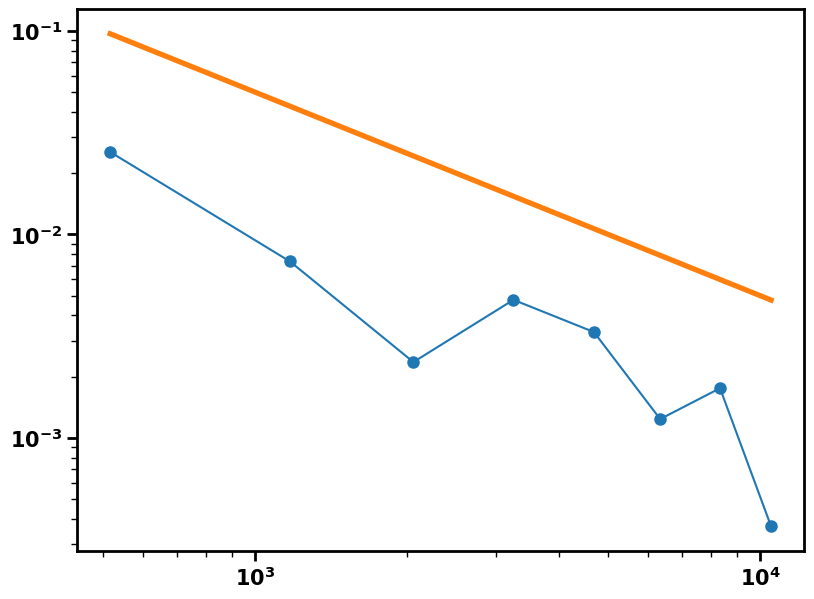

In [415]:
x = nums_Vs
cont_eig = calculate_pde_eigenvalues(1, 0) * np.sqrt(np.trace(Q / T))
y = np.abs((np.mean(eigs_data, axis=1) - cont_eig) / cont_eig)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.loglog(x[1:], y[1:], 'o-', markersize=8)
ax.loglog(x[1:], 50 * x[1:]**(-1.), linewidth=3.8)

style_plot(fig, ax, aspect=None, label_fontsize=15)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))



style_plot(fig, ax, aspect=None, label_fontsize=15)

# plt.savefig("/Users/sidneyholden/repos/metric_graph/data/tiling/random_delaunay_triangulation_periodic/c_convergence.png", dpi=200, bbox_inches="tight")
plt.show()

In [6]:
# For 10k RGG
mean_eig = np.mean([3.81421734, 3.93003284, 4.09131297, 3.99457246])

3.9575339025


In [17]:
np.random.seed(0)
pg = Delaunay_Graph(80000)
g = Patch_Graph(pg)

num_Vs = 40555


In [18]:
LHS, RHS = g.construct_alpha_solve()
alpha_x = sparseqr.solve(LHS, RHS[:, 0]) #, tolerance = 1e-9)
alpha_y = sparseqr.solve(LHS, RHS[:, 1]) #, tolerance = 1e-9)
alpha = np.hstack((alpha_x.A, alpha_y.A))
print(f"err = {np.linalg.norm(LHS @ alpha - RHS)}")

err = 1.1683164110106279e-09


In [19]:
Q = np.zeros((2, 2))
T = 0

for v_ind, w_ind in g.edges:
        
    l_vw = g.calculate_l_vw(v_ind, w_ind)
    a_vw = alpha[w_ind] - alpha[v_ind]
    q = np.tensordot(a_vw, a_vw, axes=0) / l_vw
    Q += 2 * q
    T += 2 * l_vw

for v_ind, w_ind in g.periodic_edges:
    for v_coords, w_coords in g.periodic_edges[v_ind, w_ind]:
        l_vw = np.linalg.norm(v_coords - w_coords)
        v_x_coords = g.v_coords_to_x_coords(v_coords)
        w_x_coords = g.v_coords_to_x_coords(w_coords) 
        r_xy = w_x_coords - v_x_coords
        a_vw = r_xy + alpha[w_ind] - alpha[v_ind]
        q = np.tensordot(a_vw, a_vw, axes=0) / l_vw
        Q += 2*q
        T += 2*l_vw

print(Q / T)
print(np.trace(Q / T))
# print(np.trace(Q / T) / 0.921)

[[4.60987399e-01 4.30710703e-04]
 [4.30710703e-04 4.61350941e-01]]
0.9223383397233311


In [382]:
def calculate_pde_eigenvalues(m, n):
    a = 1 / 2 
    return np.sqrt(((2 * np.pi * m)**2 + (2 * np.pi * n)**2) * a)

In [383]:
calculate_pde_eigenvalues(1, 0) * np.sqrt(np.trace(Q / T))

3.4712824235041233

In [2]:
class Delaunay_Graph(Graph, Flat):

    def __init__(self, N):

        self.N = N
        self.construct_V_coords(N)
        self.construct_data()
        self.construct_NEP_data()
        self.g_coords = self.construct_g_coords()
        print(f"num_Vs = {self.num_Vs}")
        # self.plot_graph()

    def construct_NEP_data(self):

        interior_V_num = np.arange(self.num_bulk_Vs)
        wadjacency_matrix = scipy.sparse.lil_matrix((self.num_bulk_Vs, self.num_bulk_Vs))
        E_lengths_by_v_num = {}

        for v_ind, w_ind in self.edges:
            l_vw = self.calculate_l_vw(v_ind, w_ind)
            E_lengths_by_v_num[v_ind, w_ind] = l_vw
            wrapped_v_ind = self.bulk_and_boundary_to_bulk_map[v_ind]
            wrapped_w_ind = self.bulk_and_boundary_to_bulk_map[w_ind]
            wadjacency_matrix[wrapped_v_ind, wrapped_w_ind] = l_vw
            wadjacency_matrix[wrapped_w_ind, wrapped_v_ind] = l_vw

        # Define class attributes
        self.interior_V_num = interior_V_num
        self.E_lengths_by_v_num = E_lengths_by_v_num
        self.wadjacency_matrix = wadjacency_matrix.tocsc()

    def construct_V_coords(self, N):

        full_V_coords = np.random.uniform(0 - 8, 1 + 8, size=(N, 2))

        bulk_mask = ((0 < full_V_coords[:, 0]) & (0 < full_V_coords[:, 1]) 
                     & (full_V_coords[:, 0] < 1) & (full_V_coords[:, 1] < 1))
        num_bulk_Vs = np.sum(bulk_mask)
        full_V_coords = np.vstack((full_V_coords[bulk_mask], full_V_coords[~bulk_mask]))

        # Construct bulk and boundary edges
        triangulation = scipy.spatial.Delaunay(full_V_coords)
        V, W = triangulation.vertex_neighbor_vertices
        bulk_edges = []
        boundary_edges = []
        boundary_V_inds = []
        for v_ind in range(num_bulk_Vs):
            w_inds = W[V[v_ind]:V[v_ind + 1]]
            for w_ind in w_inds:
                if v_ind < w_ind:
                    if w_ind < num_bulk_Vs:
                        bulk_edges.append([v_ind, w_ind])
                    else:
                        if not np.any(full_V_coords[w_ind] < 0):
                            boundary_edges.append([v_ind, w_ind])
                            boundary_V_inds.append(w_ind)
        bulk_edges = np.array(bulk_edges)
        boundary_edges = np.array(boundary_edges)
        boundary_V_inds = np.unique(boundary_V_inds)

        # Reindex full_V_coords to construct subset: V_coords (just bulk and boundary vertices)
        old_bulk_and_boundary_V_inds = np.concatenate((np.arange(num_bulk_Vs), boundary_V_inds))
        V_coords = full_V_coords[old_bulk_and_boundary_V_inds]

        # Fix indices in bulk and boundary edges. Create full edges
        num_boundary_Vs = boundary_V_inds.shape[0]
        new_bulk_and_boundary_V_inds = np.arange(num_bulk_Vs + num_boundary_Vs)
        old_to_new = {i: j for i, j in zip(old_bulk_and_boundary_V_inds, new_bulk_and_boundary_V_inds)}
        edges = []
        for v_ind, w_ind in np.vstack((bulk_edges, boundary_edges)):
            edges.append([old_to_new[v_ind], old_to_new[w_ind]])
        edges = np.array(edges)

        # Define class attributes
        self.full_V_coords = full_V_coords
        self.num_bulk_Vs = num_bulk_Vs
        self.num_boundary_Vs = num_boundary_Vs
        self.V_coords = V_coords
        self.num_Vs = self.V_coords.shape[0]
        self.edges = edges
        self.triangulation = triangulation

    def construct_data(self):

        # Construct boundary map
        bulk_and_boundary_to_bulk_map = {bulk_v_num: bulk_v_num for bulk_v_num in range(self.num_bulk_Vs)}
        for boundary_v_ind in range(self.num_bulk_Vs, self.num_Vs):
            wrapped_w_coord = self.V_coords[boundary_v_ind] % 1
            distances = np.linalg.norm(self.V_coords[:self.num_bulk_Vs] - wrapped_w_coord, axis=1)
            wrapped_v_ind = distances.argmin()
            bulk_and_boundary_to_bulk_map[boundary_v_ind] = wrapped_v_ind

        LHS = scipy.sparse.lil_matrix((self.num_bulk_Vs + 1, self.num_bulk_Vs))
        RHS = np.zeros((self.num_bulk_Vs + 1, 2))
        for v_ind, w_ind in self.edges:
            l_vw = self.calculate_l_vw(v_ind, w_ind)
            wrapped_v_ind = bulk_and_boundary_to_bulk_map[v_ind]
            wrapped_w_ind = bulk_and_boundary_to_bulk_map[w_ind]
            LHS[wrapped_v_ind, wrapped_w_ind] -= 1 / l_vw
            LHS[wrapped_w_ind, wrapped_v_ind] -= 1 / l_vw
            LHS[wrapped_v_ind, wrapped_v_ind] += 1 / l_vw
            LHS[wrapped_w_ind, wrapped_w_ind] += 1 / l_vw

            r_xy = self.calculate_r_xy(v_ind, w_ind)
            RHS[wrapped_v_ind] += r_xy / l_vw
            RHS[wrapped_w_ind] -= r_xy / l_vw

        LHS[-1] = np.ones(self.num_bulk_Vs)
        LHS = scipy.sparse.csc_matrix(LHS)

        self.LHS = LHS
        self.RHS = RHS
        self.bulk_and_boundary_to_bulk_map = bulk_and_boundary_to_bulk_map

    def plot_graph_manual(self):

        # Plot
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)

        ax.triplot(self.full_V_coords[:, 0], self.full_V_coords[:, 1], self.triangulation.simplices)
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)

        for i in [0]:
            for j in [0]:
                if i == 0 and j == 0: lw = 3
                else: lw = 1
                ax.add_patch(matplotlib.patches.Rectangle((i, j), 1, 1, linewidth=lw, edgecolor='orange', facecolor='none'))

        ax.scatter(self.V_coords[:self.num_bulk_Vs, 0], self.V_coords[:self.num_bulk_Vs, 1], c='b', s=1)
        ax.scatter(self.V_coords[self.num_bulk_Vs:, 0], self.V_coords[self.num_bulk_Vs:, 1], c='r', s=1)

        for en, v in enumerate(self.V_coords):
            ax.annotate(str(en), v, fontsize=20)
            if en > self.num_bulk_Vs - 1:
                ax.scatter(v[0] % 1, v[1] % 1, c='g', s=40, alpha=0.5)
                ax.annotate(str(en), v % 1, fontsize=15, alpha=0.5)

    def calculate_l_vw(self, v_ind, w_ind):
        return np.linalg.norm(self.V_coords[v_ind] - self.V_coords[w_ind])
    
    def calculate_r_xy(self, v_ind, w_ind):
        v_coords = self.V_coords[v_ind]
        w_coords = self.V_coords[w_ind]
        
        v_x_coords = self.v_coords_to_x_coords(v_coords)
        w_x_coords = self.v_coords_to_x_coords(w_coords)

        r_xy = w_x_coords - v_x_coords

        return r_xy

    def v_coords_to_x_coords(self, v_coords):
        x_coords = []
        for d in range(v_coords.shape[0]):
            if v_coords[d] < 0:
                x_coords.append(-0.5)
            elif v_coords[d] < 1:
                x_coords.append(0.5)
            else:
                x_coords.append(1.5)
        x_coords = np.array(x_coords)

        return x_coords


In [3]:
np.random.seed(3)
g = Delaunay_Graph(120000)

num_Vs = 459


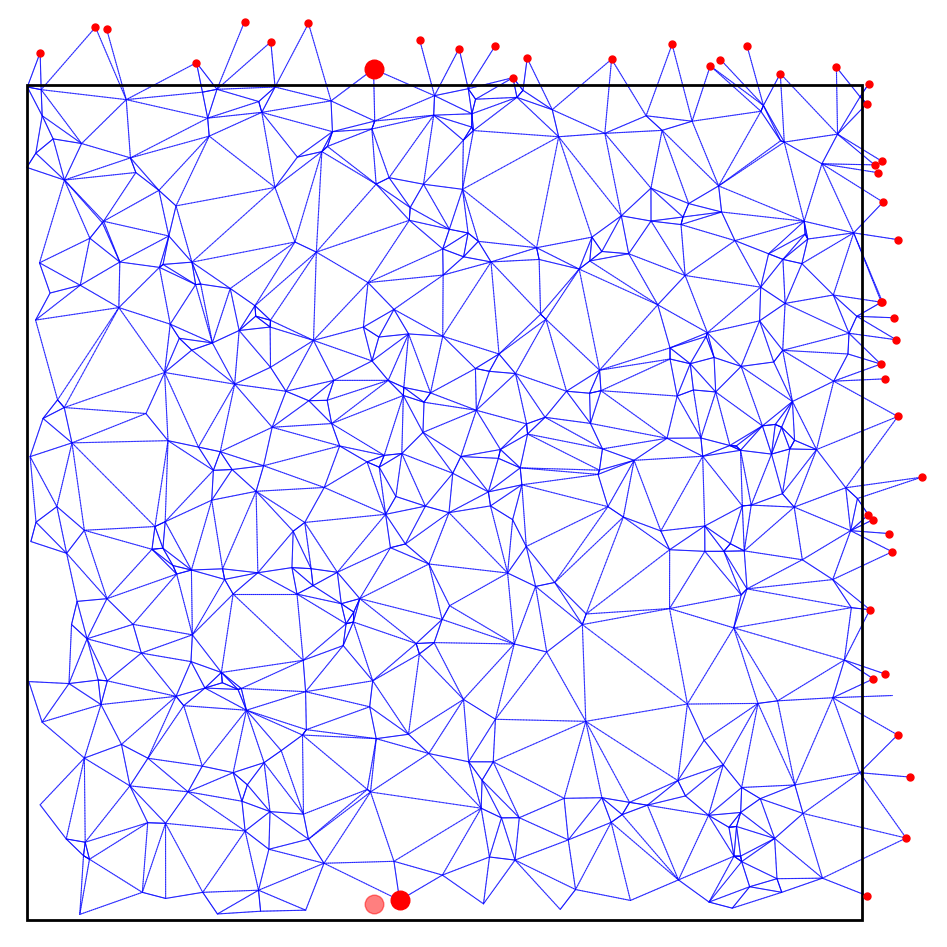

In [42]:
fig, ax = g.plot_graph(return_figax=True, linewidth=0.8, figsize=10, alpha=0.7)
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlim(-0.02, 1.09)
ax.set_ylim(-0.02, 1.09)
ax.axis('off')
# ax.triplot(g.full_V_coords[:, 0], g.full_V_coords[:, 1], g.triangulation.simplices, linewidth=1.5)
ax.scatter(g.V_coords[g.num_bulk_Vs:-1, 0], g.V_coords[g.num_bulk_Vs:-1, 1], c='r', s=25, zorder=10, alpha=1)
ax.scatter(g.V_coords[423, 0], g.V_coords[423, 1], c='r', s=180, zorder=10)
ax.scatter(g.V_coords[423, 0] % 1, g.V_coords[423, 1] % 1, c='r', s=180, zorder=10, alpha=0.5)
ax.scatter(g.V_coords[343, 0] % 1, g.V_coords[343, 1] % 1, c='r', s=180, zorder=10)
ax.add_patch(matplotlib.patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='black', facecolor='none', zorder=9))
# plt.savefig("/Users/sidneyholden/Desktop/prx_paper/figs/periodic_patch_graph.png", dpi=200, bbox_inches="tight")
plt.show()